## Notebook analysing TÜV-Nord data coming with the patent for mobile crash detection
In particular Test-files 1 and 2 and TestCA. Header descriptions are contained in _data/data.txt_. Log rate is $10Hz$ and offset for all values is zero. Before this particular analysis, I used the VBOX-Analyser from [perfdb.com](http://www.perfdb.com/) which detects possible test-cases and plots available data. Having put every dataset into that tool it seems that there have only been taken ac- and deceleration tests into account. This notebook shall provide proof for that or find more information in the provided dataset in csv-format.

In [90]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
#matplotlib.style.available
matplotlib.style.use('seaborn-notebook')
import pylab as plt

Import Testfiles and drop columns containing no information. In case of _data/Test1.csv_ we can drop **yaw-calc, slip, YAW__, YAW_**.

In [58]:
data1 = pd.read_csv('data/Test1.csv')
data2 = pd.read_csv('data/Test2.csv')
dataCA = pd.read_csv('data/TestCA.csv')

Clean tables from previously enumerated columns. These store no information due to either zero variance or invalid file readings caused by a corrupt csv file.

In [59]:
def convert_and_clean(frame):
    for head in frame:
        if 'object:dense' in frame[head].ftypes:
            frame[head] = frame[head].apply(lambda x: x.replace(',', '.').replace('+', ''))
            frame[head] = frame[head].astype(float)
        var = 1.0
        try:
            var = frame[head].var()
        except:
            continue
        if 'Unnamed' in head or var == 0:
            frame = frame.drop(head, axis=1)
    return frame

In [60]:
data1 = convert_and_clean(data1)
data2 = convert_and_clean(data2)
dataCA = convert_and_clean(dataCA)

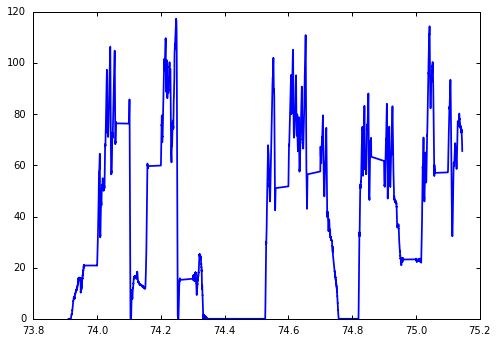

In [97]:
plt.style.use('seaborn-notebook')
plt.plot(data1['time'].apply(lambda x: (x/1000)), data1['velocity'])
plt.show()

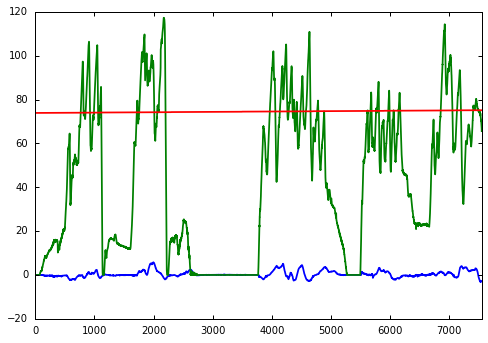

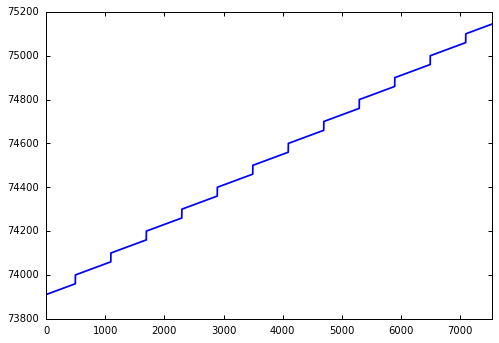

In [98]:
matplotlib.style.use('seaborn-notebook')
data1 = data1.sort_values(by=['time'])
data2 = data2.sort_values(by=['time'])
#data1['time'].plot()
data1['vert-vel'].plot()
data1['velocity'].plot()
#data1['sats'].plot()
start_time = data1['time'].min()
data1['time'].apply(lambda x: (x / 1000)).plot()
matplotlib.pyplot.show()
data1['time'].plot()

In [68]:
data1

,sats,time,lat,long,velocity,heading,height,vert-vel
0,8,73910.5,2473.74133,-100.58397,0.00,0.00,102.45,0.000
1,8,73910.6,2473.74133,-100.58397,0.00,280.68,102.45,0.000
2,8,73910.7,2473.74133,-100.58396,0.00,154.27,102.45,0.000
3,8,73910.8,2473.74133,-100.58396,0.00,154.27,102.45,0.000
4,8,73910.9,2473.74134,-100.58395,0.00,303.40,102.45,0.000
5,8,73911.0,2473.74134,-100.58395,0.00,75.39,102.46,0.000
6,8,73911.1,2473.74134,-100.58394,0.00,225.76,102.46,0.000
7,8,73911.2,2473.74134,-100.58394,0.00,225.76,102.46,0.000
8,8,73911.3,2473.74134,-100.58394,0.00,225.76,102.46,0.000
9,8,73911.4,2473.74134,-100.58394,0.00,87.81,102.47,0.000
